In [2]:
import numpy as np
import pandas as pd


from sklearn.cross_validation import cross_val_score

import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn import pipeline, preprocessing, feature_extraction
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import os

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
d = 'data/pan18-style-change-detection-training-dataset-2018-01-31/'
train_files = os.listdir(d)

truth_files = []
text_files = []
for i in train_files:
    if 'truth' in i:
        truth_files += [i]
    else:
        text_files += [i]
        
truth_files = np.sort(truth_files)
text_files = np.sort(text_files)


texts = []
truths = []
for i, j in zip(text_files, truth_files):
    file = open(d+i, 'r') 
    texts += [file.read()]
    
    file = open(d+j, 'r') 
    truths += [file.read()]
    
df = pd.DataFrame(texts)
df.columns = ['text']
df['coord'] = truths
df['coord'] = df['coord'].apply(lambda x: x.split('[')[1].split(']')[0])


d = 'data/pan18-style-change-detection-validation-dataset-2018-01-31/'
train_files = os.listdir(d)

truth_files = []
text_files = []
for i in train_files:
    if 'truth' in i:
        truth_files += [i]
    else:
        text_files += [i]
        
truth_files = np.sort(truth_files)
text_files = np.sort(text_files)


texts = []
truths = []
for i, j in zip(text_files, truth_files):
    file = open(d+i, 'r') 
    texts += [file.read()]
    
    file = open(d+j, 'r') 
    truths += [file.read()]
    
df_val = pd.DataFrame(texts)
df_val.columns = ['text']
df_val['coord'] = truths
df_val['coord'] = df_val['coord'].apply(lambda x: x.split('[')[1].split(']')[0])

In [7]:
df['text'].apply(lambda x: len(x.split(' '))).max()

1860

In [34]:
!nvidia-smi

Sun Apr 22 16:59:19 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 64%   75C    P2    89W / 180W |   7749MiB /  8113MiB |     72%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

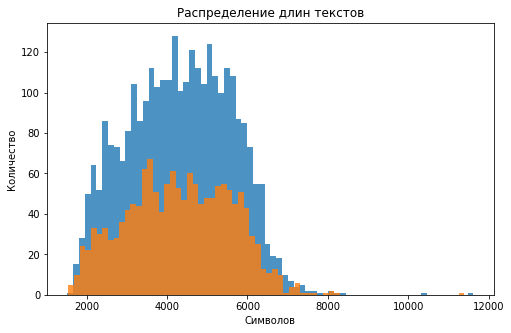

In [3]:
plt.figure(figsize=(8,5))
plt.title('Распределение длин текстов')
plt.ylabel('Количество')
plt.xlabel('Символов')
plt.hist(df['text'].apply(lambda x: len(x)).values, bins=70, alpha=0.8)
plt.hist(df_val['text'].apply(lambda x: len(x)).values, bins=70, alpha=0.8)

plt.show()

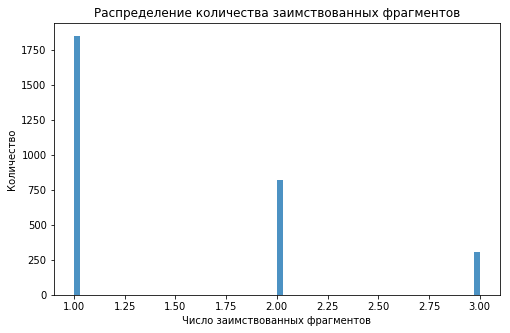

In [4]:
plt.figure(figsize=(8,5))
plt.title('Распределение количества заимствованных фрагментов')
plt.ylabel('Количество')
plt.xlabel('Число заимствованных фрагментов')
plt.hist(df['coord'].apply(lambda x: len(x.split(','))).values, bins=70, alpha=0.8)

plt.show()

In [5]:
df['text'] = df['text'].apply(lambda x: str(x))
df_val['text'] = df_val['text'].apply(lambda x: str(x))

In [6]:
df['text'] = df['text'].apply(lambda x: x.lower().split())
df_val['text'] = df_val['text'].apply(lambda x: x.lower().split())

In [17]:
X1 = map(lambda x: ' '.join(x), df['text'])
Y1 = map(lambda x: ' '.join(x), df_val['text'])

hw1 = HashingVectorizer(n_features=1000).fit(df['text'] + df_val['text'])

In [18]:
X1 = pd.DataFrame(hw1.transform(X1).todense())
Y1 = pd.DataFrame(hw1.transform(Y1).todense())

In [19]:
tfidf = feature_extraction.text.TfidfTransformer()
tfidf.fit(X1+Y1)

X1 = pd.DataFrame(tfidf.transform(X1).todense())
Y1 = pd.DataFrame(tfidf.transform(Y1).todense())

In [20]:
y_train = df['coord'].apply(lambda x: len(x) > 0)
y_val = df_val['coord'].apply(lambda x: len(x) > 0)

In [32]:
#LGBM
params = {
    #'task': 'train',
    #'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'application': 'multiclass',
    'objective':'binary',
    #'num_leaves': 31,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'subsample': 0.8,
    'colsample_bytree': 0.8,
    #'objective': 'multiclass',
    'nthread': -1,
    'learning_rate': 0.1,
    #'min_child_weight': 50,
    'max_depth': 9
    #'num_class': 2302,
    #'feature_fraction':0.2,
    #'bagging_fraction':0.5
    
}




#Xdatatrain = xgb.DMatrix(data=X_train.values,
#                             label=y_train.values)
#Xdataval = xgb.DMatrix(data=X_val.values,
#                             label=y_val.values)
#plst = list(param.items())
#watchlist = [(Xdatatrain, 'train'), (Xdataval, 'eval')]

#bst = xgb.train(plst, Xdatatrain, numround, evals=watchlist, verbose_eval=1)

lgb = lgbm.sklearn.LGBMClassifier(n_estimators=700, seed=0, **params)
lgb.fit(X1, y_train.values)
#ypred = lgb.predict_proba(X_train.ix[ite, :])[:, 1]


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_depth=9, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=700,
        n_jobs=-1, nthread=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=1)

In [33]:
from sklearn.metrics import accuracy_score
y_pred = lgb.predict_proba(Y1)[:,1]
accuracy_score(y_val, y_pred > 0.5)

0.6467828418230563

In [24]:
0.6812546228946561
0.6794425548455621
0.6595174262734584

In [27]:
y_val.shape

(1492,)

In [30]:
y_val.sum() / len(y_val)

0.5

In [7]:
pd.read_csv('predictions/tfidf_1.csv').max()

0    0.0
dtype: float64